# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [99]:
# can comment out after executing
!unzip -n processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [45]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
# import helper
import matplotlib.image as mpimg
%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [7]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    # TODO: Implement function and return a dataloader
    transformed = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    ])

    data = datasets.ImageFolder(data_dir, transform=transformed)
    
    
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,  shuffle=True, num_workers=0)

    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = (32,32)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

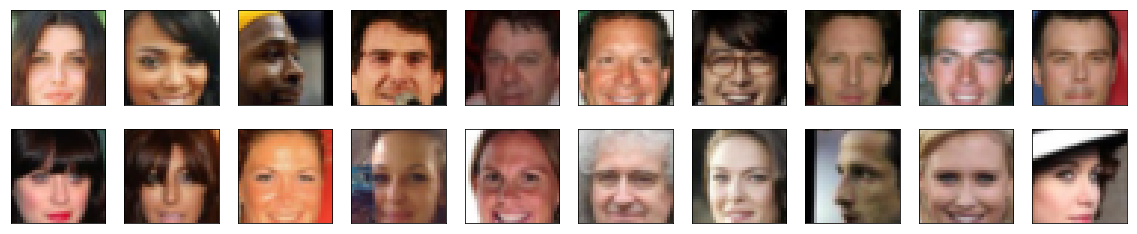

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [3]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min) + min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8118)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2,padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
        
def deconv(in_channels, out_channels, kernel_size, stride=2,padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        # complete init function
        # input: (32,32,3)
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) #(16,16,32)
        self.conv2 = conv(conv_dim, conv_dim*2, 4) #(8,8, 64)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) #(4,4, 128)
        
        self.fc1 = nn.Linear(4*4*conv_dim*4, 1) #(2048,1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, 4*4*self.conv_dim*4)
        
        x = self.fc1(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        # complete init function
        self.fc = nn.Linear(z_size,4*4*(conv_dim*4)) #reshape to (z_size, 256,4,4)
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4) # (4*4*128)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4) # (8*8*)
        self.deconv3 = deconv(conv_dim, 3, 4)
        self.deconv4_res = deconv(3, 3, 1, stride=1, padding=0)
        self.deconv5_res = deconv(3,3,1, stride=1, padding=0)
        self.deconv6 = deconv(3, 3, 1, stride=1, padding=0, batch_norm=False)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x) # (conv_dim, 2048)
        x = x.view(-1,self.conv_dim*4,4,4) #(128, 4,4)
        
        x = self.deconv1(x) # (64, 8, 8)
        self.dropout(x)
        x = F.relu(x)
        
        x = self.deconv2(x)  # (32,16,16)
        x = F.relu(x)
        self.dropout(x)
        
        x = self.deconv3(x) #(3, 32,32)
        x = x+F.relu(x)
        self.dropout(x)
        
        x = self.deconv4_res(x) # (3,32,32)
        x = x+F.relu(x)
        self.dropout(x)
        
        x = x + self.deconv5_res(x) #(3,32,32)
        self.dropout(x)
        
        x = x + self.deconv6(x) #(3,32,32)
#         self.dropout(x)
        out = torch.tanh(x) 
        
        return out
    
"""

DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [18]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    lr = 0.01
    # TODO: Apply initial weights to convolutional and linear layers
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
                m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [20]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [21]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    labels = torch.ones(D_out.size(0)) * 0.9 #smoothing by default
    criterion = nn.BCEWithLogitsLoss()
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    labels = torch.zeros(D_out.size(0))
    criterion = nn.BCEWithLogitsLoss()
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

lr= 0.0002
beta1 = 0.5
beta2 = 0.9999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            ############# 1. Train the discriminator on real and fake images #############
            d_optimizer.zero_grad()
            
            # Train on discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)
            
            #generate the fake image
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # calculate loss of fake image in discriminator
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            #add their losses
            d_loss = d_real_loss +  d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            ############## 2. Train the generator with an adversarial loss##############
            g_optimizer.zero_grad()
            
            #generate the fake image
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # calculate loss of fake image in discriminator for generator
            d_fake = D(fake_images)

            g_loss = real_loss(d_fake)

            g_loss.backward()
            g_optimizer.step()
    
    
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    #save our model
    torch.save(G.state_dict(), 'G.pth')
    torch.save(D.state_dict(), 'D.pth')
    
    # finally return losses
    return losses



Set your number of training epochs and train your GAN!

In [20]:
from workspace import keep_awake
from workspace import active_session
# set number of epochs 

n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
for i in keep_awake(range(1)):
    with active_session():
        losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.5506 | g_loss: 0.6429
Epoch [    1/  100] | d_loss: 0.3948 | g_loss: 2.7610
Epoch [    1/  100] | d_loss: 0.3554 | g_loss: 3.7528
Epoch [    1/  100] | d_loss: 0.3409 | g_loss: 4.4732
Epoch [    1/  100] | d_loss: 0.3376 | g_loss: 4.8963
Epoch [    1/  100] | d_loss: 0.3432 | g_loss: 4.6623
Epoch [    1/  100] | d_loss: 0.3477 | g_loss: 4.8133
Epoch [    1/  100] | d_loss: 0.3495 | g_loss: 4.8539
Epoch [    1/  100] | d_loss: 0.4726 | g_loss: 3.8105
Epoch [    1/  100] | d_loss: 0.4445 | g_loss: 3.0628
Epoch [    1/  100] | d_loss: 0.4011 | g_loss: 3.8975
Epoch [    1/  100] | d_loss: 0.7262 | g_loss: 4.7674
Epoch [    1/  100] | d_loss: 0.4936 | g_loss: 2.2558
Epoch [    1/  100] | d_loss: 0.5689 | g_loss: 2.0318
Epoch [    1/  100] | d_loss: 0.4929 | g_loss: 2.1540
Epoch [    1/  100] | d_loss: 1.1061 | g_loss: 0.9348
Epoch [    1/  100] | d_loss: 0.6955 | g_loss: 2.5881
Epoch [    1/  100] | d_loss: 0.4916 | g_loss: 2.7176
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.8881 | g_loss: 1.4593
Epoch [    3/  100] | d_loss: 0.9197 | g_loss: 0.9188
Epoch [    3/  100] | d_loss: 0.9186 | g_loss: 1.0046
Epoch [    3/  100] | d_loss: 0.5646 | g_loss: 1.9980
Epoch [    3/  100] | d_loss: 0.7587 | g_loss: 0.8936
Epoch [    3/  100] | d_loss: 0.8465 | g_loss: 1.1615
Epoch [    3/  100] | d_loss: 0.9368 | g_loss: 1.5875
Epoch [    3/  100] | d_loss: 0.8604 | g_loss: 0.9942
Epoch [    3/  100] | d_loss: 1.0948 | g_loss: 1.4016
Epoch [    3/  100] | d_loss: 0.9098 | g_loss: 0.9930
Epoch [    3/  100] | d_loss: 0.8335 | g_loss: 1.0267
Epoch [    3/  100] | d_loss: 0.8537 | g_loss: 1.5714
Epoch [    3/  100] | d_loss: 0.9209 | g_loss: 1.3963
Epoch [    3/  100] | d_loss: 0.9400 | g_loss: 1.1728
Epoch [    3/  100] | d_loss: 1.0892 | g_loss: 1.6830
Epoch [    3/  100] | d_loss: 1.0166 | g_loss: 1.6027
Epoch [    3/  100] | d_loss: 1.0834 | g_loss: 1.6404
Epoch [    3/  100] | d_loss: 0.9252 | g_loss: 1.6422
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.7927 | g_loss: 1.8544
Epoch [    6/  100] | d_loss: 0.7334 | g_loss: 2.1492
Epoch [    6/  100] | d_loss: 0.7974 | g_loss: 1.2422
Epoch [    6/  100] | d_loss: 1.0323 | g_loss: 3.2549
Epoch [    6/  100] | d_loss: 0.6719 | g_loss: 2.1608
Epoch [    6/  100] | d_loss: 0.7196 | g_loss: 1.5701
Epoch [    6/  100] | d_loss: 0.8134 | g_loss: 1.3100
Epoch [    6/  100] | d_loss: 1.0321 | g_loss: 1.4617
Epoch [    6/  100] | d_loss: 1.0407 | g_loss: 1.5027
Epoch [    6/  100] | d_loss: 0.7205 | g_loss: 1.7762
Epoch [    6/  100] | d_loss: 0.7676 | g_loss: 1.3677
Epoch [    6/  100] | d_loss: 0.8319 | g_loss: 2.2337
Epoch [    6/  100] | d_loss: 0.7020 | g_loss: 1.6649
Epoch [    6/  100] | d_loss: 0.7700 | g_loss: 1.8711
Epoch [    6/  100] | d_loss: 0.8133 | g_loss: 1.3312
Epoch [    6/  100] | d_loss: 0.7981 | g_loss: 1.2742
Epoch [    6/  100] | d_loss: 0.8693 | g_loss: 1.3072
Epoch [    6/  100] | d_loss: 0.7522 | g_loss: 1.8732
Epoch [    6/  100] | d_loss

Epoch [    9/  100] | d_loss: 1.1976 | g_loss: 1.0989
Epoch [    9/  100] | d_loss: 0.6317 | g_loss: 1.6751
Epoch [    9/  100] | d_loss: 1.4877 | g_loss: 1.1370
Epoch [    9/  100] | d_loss: 0.7530 | g_loss: 2.0007
Epoch [    9/  100] | d_loss: 0.7876 | g_loss: 1.7148
Epoch [    9/  100] | d_loss: 0.7217 | g_loss: 2.1710
Epoch [    9/  100] | d_loss: 0.6935 | g_loss: 2.1864
Epoch [    9/  100] | d_loss: 0.7102 | g_loss: 2.5740
Epoch [    9/  100] | d_loss: 0.6436 | g_loss: 2.3018
Epoch [    9/  100] | d_loss: 0.6225 | g_loss: 2.2346
Epoch [    9/  100] | d_loss: 0.7291 | g_loss: 2.2568
Epoch [    9/  100] | d_loss: 0.8314 | g_loss: 1.8483
Epoch [    9/  100] | d_loss: 0.8976 | g_loss: 3.2021
Epoch [    9/  100] | d_loss: 0.8589 | g_loss: 1.4907
Epoch [    9/  100] | d_loss: 0.6096 | g_loss: 1.8793
Epoch [    9/  100] | d_loss: 0.5331 | g_loss: 2.1021
Epoch [    9/  100] | d_loss: 0.6180 | g_loss: 2.1187
Epoch [    9/  100] | d_loss: 0.7794 | g_loss: 2.2218
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.7131 | g_loss: 2.4787
Epoch [   11/  100] | d_loss: 0.6390 | g_loss: 1.3371
Epoch [   11/  100] | d_loss: 0.8146 | g_loss: 1.5699
Epoch [   11/  100] | d_loss: 0.7822 | g_loss: 1.3107
Epoch [   11/  100] | d_loss: 0.4991 | g_loss: 2.1299
Epoch [   11/  100] | d_loss: 0.5885 | g_loss: 2.6965
Epoch [   11/  100] | d_loss: 0.5435 | g_loss: 2.0999
Epoch [   11/  100] | d_loss: 0.5213 | g_loss: 2.6602
Epoch [   11/  100] | d_loss: 0.4769 | g_loss: 2.4468
Epoch [   11/  100] | d_loss: 0.8381 | g_loss: 1.8027
Epoch [   11/  100] | d_loss: 0.8118 | g_loss: 1.8254
Epoch [   11/  100] | d_loss: 0.5219 | g_loss: 3.0446
Epoch [   11/  100] | d_loss: 0.7528 | g_loss: 1.7386
Epoch [   11/  100] | d_loss: 1.0077 | g_loss: 2.5333
Epoch [   11/  100] | d_loss: 0.5414 | g_loss: 3.3092
Epoch [   11/  100] | d_loss: 0.7530 | g_loss: 1.8821
Epoch [   11/  100] | d_loss: 0.5267 | g_loss: 2.4857
Epoch [   11/  100] | d_loss: 0.8305 | g_loss: 1.8725
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.5979 | g_loss: 2.9816
Epoch [   14/  100] | d_loss: 0.7245 | g_loss: 3.3475
Epoch [   14/  100] | d_loss: 0.8250 | g_loss: 3.0659
Epoch [   14/  100] | d_loss: 0.5546 | g_loss: 2.3332
Epoch [   14/  100] | d_loss: 0.5694 | g_loss: 2.6827
Epoch [   14/  100] | d_loss: 0.8218 | g_loss: 3.1292
Epoch [   14/  100] | d_loss: 0.5939 | g_loss: 1.1999
Epoch [   14/  100] | d_loss: 0.5552 | g_loss: 2.3753
Epoch [   14/  100] | d_loss: 0.5490 | g_loss: 2.2904
Epoch [   14/  100] | d_loss: 0.7697 | g_loss: 2.0995
Epoch [   14/  100] | d_loss: 0.6525 | g_loss: 2.4505
Epoch [   14/  100] | d_loss: 0.7770 | g_loss: 1.3614
Epoch [   14/  100] | d_loss: 0.7235 | g_loss: 2.0853
Epoch [   14/  100] | d_loss: 0.4585 | g_loss: 2.6786
Epoch [   14/  100] | d_loss: 0.5091 | g_loss: 2.8436
Epoch [   14/  100] | d_loss: 0.6211 | g_loss: 2.9372
Epoch [   14/  100] | d_loss: 0.6604 | g_loss: 1.9447
Epoch [   14/  100] | d_loss: 0.6205 | g_loss: 2.3754
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.5658 | g_loss: 1.9891
Epoch [   17/  100] | d_loss: 1.0944 | g_loss: 1.4464
Epoch [   17/  100] | d_loss: 0.6059 | g_loss: 2.9554
Epoch [   17/  100] | d_loss: 0.6493 | g_loss: 2.4881
Epoch [   17/  100] | d_loss: 0.6162 | g_loss: 3.1604
Epoch [   17/  100] | d_loss: 0.5665 | g_loss: 2.9561
Epoch [   17/  100] | d_loss: 0.4833 | g_loss: 2.8444
Epoch [   17/  100] | d_loss: 0.9927 | g_loss: 1.4365
Epoch [   17/  100] | d_loss: 0.6728 | g_loss: 1.8480
Epoch [   17/  100] | d_loss: 0.5473 | g_loss: 2.9104
Epoch [   17/  100] | d_loss: 0.5096 | g_loss: 3.2304
Epoch [   17/  100] | d_loss: 0.9172 | g_loss: 1.5965
Epoch [   17/  100] | d_loss: 0.4228 | g_loss: 3.4875
Epoch [   17/  100] | d_loss: 1.2679 | g_loss: 0.9540
Epoch [   17/  100] | d_loss: 0.6519 | g_loss: 2.1547
Epoch [   17/  100] | d_loss: 0.5036 | g_loss: 2.5550
Epoch [   17/  100] | d_loss: 0.5607 | g_loss: 3.0368
Epoch [   17/  100] | d_loss: 0.7279 | g_loss: 2.6795
Epoch [   17/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.5333 | g_loss: 3.3682
Epoch [   19/  100] | d_loss: 0.7455 | g_loss: 3.0976
Epoch [   19/  100] | d_loss: 0.5239 | g_loss: 2.3159
Epoch [   19/  100] | d_loss: 0.9024 | g_loss: 3.2083
Epoch [   19/  100] | d_loss: 0.4059 | g_loss: 3.5672
Epoch [   19/  100] | d_loss: 0.6259 | g_loss: 3.3671
Epoch [   19/  100] | d_loss: 0.7703 | g_loss: 1.9919
Epoch [   19/  100] | d_loss: 0.6060 | g_loss: 1.9685
Epoch [   19/  100] | d_loss: 0.6884 | g_loss: 2.1872
Epoch [   19/  100] | d_loss: 0.6752 | g_loss: 1.8764
Epoch [   19/  100] | d_loss: 0.5221 | g_loss: 2.8824
Epoch [   19/  100] | d_loss: 0.6131 | g_loss: 3.4760
Epoch [   19/  100] | d_loss: 0.4851 | g_loss: 1.5193
Epoch [   19/  100] | d_loss: 0.6748 | g_loss: 1.3850
Epoch [   19/  100] | d_loss: 0.4825 | g_loss: 3.1913
Epoch [   19/  100] | d_loss: 0.6290 | g_loss: 2.5329
Epoch [   19/  100] | d_loss: 0.5695 | g_loss: 2.4408
Epoch [   19/  100] | d_loss: 0.7054 | g_loss: 2.1812
Epoch [   19/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.4355 | g_loss: 3.1334
Epoch [   22/  100] | d_loss: 0.7107 | g_loss: 2.6659
Epoch [   22/  100] | d_loss: 0.4881 | g_loss: 3.5274
Epoch [   22/  100] | d_loss: 0.6989 | g_loss: 1.8374
Epoch [   22/  100] | d_loss: 0.5027 | g_loss: 3.3232
Epoch [   22/  100] | d_loss: 0.6737 | g_loss: 2.8374
Epoch [   22/  100] | d_loss: 1.0538 | g_loss: 3.0836
Epoch [   22/  100] | d_loss: 0.4473 | g_loss: 3.2853
Epoch [   22/  100] | d_loss: 0.7560 | g_loss: 2.7073
Epoch [   22/  100] | d_loss: 0.4226 | g_loss: 3.2911
Epoch [   22/  100] | d_loss: 0.4826 | g_loss: 2.4091
Epoch [   22/  100] | d_loss: 0.4708 | g_loss: 2.9560
Epoch [   22/  100] | d_loss: 0.4788 | g_loss: 2.7322
Epoch [   22/  100] | d_loss: 0.4597 | g_loss: 2.9909
Epoch [   22/  100] | d_loss: 1.8378 | g_loss: 5.1288
Epoch [   22/  100] | d_loss: 0.8062 | g_loss: 2.7532
Epoch [   22/  100] | d_loss: 0.6724 | g_loss: 2.4656
Epoch [   22/  100] | d_loss: 0.4740 | g_loss: 2.7527
Epoch [   22/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.8138 | g_loss: 3.0114
Epoch [   25/  100] | d_loss: 0.9342 | g_loss: 2.5554
Epoch [   25/  100] | d_loss: 0.4289 | g_loss: 3.5795
Epoch [   25/  100] | d_loss: 0.4940 | g_loss: 2.7759
Epoch [   25/  100] | d_loss: 0.5306 | g_loss: 2.7057
Epoch [   25/  100] | d_loss: 0.9161 | g_loss: 3.4979
Epoch [   25/  100] | d_loss: 0.5901 | g_loss: 3.2637
Epoch [   25/  100] | d_loss: 0.4809 | g_loss: 3.9714
Epoch [   25/  100] | d_loss: 0.5936 | g_loss: 2.5365
Epoch [   25/  100] | d_loss: 0.5376 | g_loss: 3.5198
Epoch [   25/  100] | d_loss: 0.4243 | g_loss: 3.0795
Epoch [   25/  100] | d_loss: 0.4966 | g_loss: 3.4278
Epoch [   25/  100] | d_loss: 0.6433 | g_loss: 2.6815
Epoch [   25/  100] | d_loss: 0.8317 | g_loss: 1.2901
Epoch [   25/  100] | d_loss: 0.4349 | g_loss: 2.0344
Epoch [   25/  100] | d_loss: 0.4921 | g_loss: 3.0013
Epoch [   25/  100] | d_loss: 0.5146 | g_loss: 2.8284
Epoch [   25/  100] | d_loss: 0.4575 | g_loss: 1.9599
Epoch [   25/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.7250 | g_loss: 2.7067
Epoch [   27/  100] | d_loss: 0.4303 | g_loss: 3.1559
Epoch [   27/  100] | d_loss: 0.4750 | g_loss: 2.6832
Epoch [   27/  100] | d_loss: 0.6459 | g_loss: 3.0126
Epoch [   27/  100] | d_loss: 0.6746 | g_loss: 2.0655
Epoch [   27/  100] | d_loss: 0.7378 | g_loss: 2.5179
Epoch [   27/  100] | d_loss: 0.4264 | g_loss: 3.0766
Epoch [   27/  100] | d_loss: 0.5093 | g_loss: 3.6539
Epoch [   27/  100] | d_loss: 0.5110 | g_loss: 2.9929
Epoch [   27/  100] | d_loss: 0.4883 | g_loss: 2.9824
Epoch [   27/  100] | d_loss: 0.4915 | g_loss: 2.1373
Epoch [   27/  100] | d_loss: 0.8276 | g_loss: 2.4570
Epoch [   27/  100] | d_loss: 0.5978 | g_loss: 2.9947
Epoch [   27/  100] | d_loss: 0.4262 | g_loss: 3.0481
Epoch [   27/  100] | d_loss: 0.7266 | g_loss: 3.1819
Epoch [   27/  100] | d_loss: 0.4853 | g_loss: 3.5926
Epoch [   27/  100] | d_loss: 0.5157 | g_loss: 3.0255
Epoch [   27/  100] | d_loss: 0.5459 | g_loss: 3.3479
Epoch [   27/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.4571 | g_loss: 3.6450
Epoch [   30/  100] | d_loss: 0.4887 | g_loss: 3.0809
Epoch [   30/  100] | d_loss: 0.6423 | g_loss: 2.4868
Epoch [   30/  100] | d_loss: 0.4455 | g_loss: 2.6987
Epoch [   30/  100] | d_loss: 0.4123 | g_loss: 3.2038
Epoch [   30/  100] | d_loss: 0.4016 | g_loss: 3.6910
Epoch [   30/  100] | d_loss: 0.4611 | g_loss: 3.0895
Epoch [   30/  100] | d_loss: 0.6147 | g_loss: 2.0668
Epoch [   30/  100] | d_loss: 0.4726 | g_loss: 3.0407
Epoch [   30/  100] | d_loss: 0.4362 | g_loss: 3.8009
Epoch [   30/  100] | d_loss: 0.4475 | g_loss: 3.2257
Epoch [   30/  100] | d_loss: 0.6640 | g_loss: 3.1538
Epoch [   30/  100] | d_loss: 1.1038 | g_loss: 1.2994
Epoch [   30/  100] | d_loss: 0.7422 | g_loss: 2.1300
Epoch [   30/  100] | d_loss: 0.4277 | g_loss: 4.2952
Epoch [   30/  100] | d_loss: 0.4332 | g_loss: 2.9236
Epoch [   30/  100] | d_loss: 0.4409 | g_loss: 3.6870
Epoch [   30/  100] | d_loss: 0.4690 | g_loss: 3.7636
Epoch [   30/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.4637 | g_loss: 3.0884
Epoch [   33/  100] | d_loss: 0.4086 | g_loss: 4.3947
Epoch [   33/  100] | d_loss: 0.4407 | g_loss: 1.7534
Epoch [   33/  100] | d_loss: 0.4624 | g_loss: 4.2926
Epoch [   33/  100] | d_loss: 0.4322 | g_loss: 3.4223
Epoch [   33/  100] | d_loss: 0.4320 | g_loss: 2.0561
Epoch [   33/  100] | d_loss: 0.4833 | g_loss: 3.6659
Epoch [   33/  100] | d_loss: 0.4918 | g_loss: 3.3941
Epoch [   33/  100] | d_loss: 0.4807 | g_loss: 3.3628
Epoch [   33/  100] | d_loss: 0.3991 | g_loss: 3.7297
Epoch [   33/  100] | d_loss: 0.4368 | g_loss: 3.9492
Epoch [   33/  100] | d_loss: 0.5279 | g_loss: 3.8398
Epoch [   33/  100] | d_loss: 0.4095 | g_loss: 3.3328
Epoch [   33/  100] | d_loss: 0.3888 | g_loss: 3.9080
Epoch [   33/  100] | d_loss: 0.4787 | g_loss: 4.0966
Epoch [   33/  100] | d_loss: 1.5293 | g_loss: 1.4780
Epoch [   33/  100] | d_loss: 0.4053 | g_loss: 4.2082
Epoch [   33/  100] | d_loss: 0.5034 | g_loss: 3.3964
Epoch [   33/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.4545 | g_loss: 2.8270
Epoch [   35/  100] | d_loss: 0.4960 | g_loss: 2.5874
Epoch [   35/  100] | d_loss: 0.4516 | g_loss: 3.0770
Epoch [   35/  100] | d_loss: 0.8105 | g_loss: 2.9925
Epoch [   35/  100] | d_loss: 0.6227 | g_loss: 3.5093
Epoch [   35/  100] | d_loss: 0.6349 | g_loss: 3.1844
Epoch [   35/  100] | d_loss: 0.9419 | g_loss: 5.4005
Epoch [   35/  100] | d_loss: 0.4229 | g_loss: 3.9674
Epoch [   35/  100] | d_loss: 0.4168 | g_loss: 4.6448
Epoch [   35/  100] | d_loss: 0.4171 | g_loss: 3.6275
Epoch [   35/  100] | d_loss: 0.4398 | g_loss: 3.2477
Epoch [   35/  100] | d_loss: 0.4331 | g_loss: 3.1075
Epoch [   35/  100] | d_loss: 0.5560 | g_loss: 2.6988
Epoch [   35/  100] | d_loss: 0.4552 | g_loss: 3.3017
Epoch [   35/  100] | d_loss: 0.6689 | g_loss: 2.0850
Epoch [   35/  100] | d_loss: 0.3930 | g_loss: 4.4143
Epoch [   35/  100] | d_loss: 0.3848 | g_loss: 3.3874
Epoch [   35/  100] | d_loss: 0.4122 | g_loss: 2.9342
Epoch [   35/  100] | d_loss

Epoch [   38/  100] | d_loss: 0.5309 | g_loss: 2.9530
Epoch [   38/  100] | d_loss: 0.4674 | g_loss: 3.3254
Epoch [   38/  100] | d_loss: 0.3848 | g_loss: 3.5648
Epoch [   38/  100] | d_loss: 0.4082 | g_loss: 4.1164
Epoch [   38/  100] | d_loss: 0.4278 | g_loss: 3.2411
Epoch [   38/  100] | d_loss: 0.6040 | g_loss: 2.4007
Epoch [   38/  100] | d_loss: 0.8787 | g_loss: 1.1266
Epoch [   38/  100] | d_loss: 0.4014 | g_loss: 4.8760
Epoch [   38/  100] | d_loss: 0.4543 | g_loss: 3.4666
Epoch [   38/  100] | d_loss: 0.4988 | g_loss: 2.8534
Epoch [   38/  100] | d_loss: 0.4083 | g_loss: 4.0668
Epoch [   38/  100] | d_loss: 0.4428 | g_loss: 2.5416
Epoch [   38/  100] | d_loss: 0.4444 | g_loss: 3.3584
Epoch [   38/  100] | d_loss: 0.5256 | g_loss: 2.5233
Epoch [   38/  100] | d_loss: 0.6623 | g_loss: 2.2462
Epoch [   38/  100] | d_loss: 0.4141 | g_loss: 3.2098
Epoch [   38/  100] | d_loss: 0.4717 | g_loss: 3.2125
Epoch [   38/  100] | d_loss: 0.4034 | g_loss: 2.8362
Epoch [   38/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.4351 | g_loss: 2.9975
Epoch [   41/  100] | d_loss: 0.4340 | g_loss: 4.5428
Epoch [   41/  100] | d_loss: 0.3711 | g_loss: 3.5770
Epoch [   41/  100] | d_loss: 0.4506 | g_loss: 3.2782
Epoch [   41/  100] | d_loss: 0.3711 | g_loss: 4.3527
Epoch [   41/  100] | d_loss: 0.4666 | g_loss: 4.0512
Epoch [   41/  100] | d_loss: 0.3984 | g_loss: 4.8579
Epoch [   41/  100] | d_loss: 0.4272 | g_loss: 2.9574
Epoch [   41/  100] | d_loss: 0.3797 | g_loss: 3.6566
Epoch [   41/  100] | d_loss: 0.4319 | g_loss: 2.5454
Epoch [   41/  100] | d_loss: 0.3969 | g_loss: 3.5681
Epoch [   41/  100] | d_loss: 0.4157 | g_loss: 4.1284
Epoch [   41/  100] | d_loss: 0.4404 | g_loss: 4.3526
Epoch [   41/  100] | d_loss: 0.5258 | g_loss: 2.6115
Epoch [   41/  100] | d_loss: 0.4418 | g_loss: 4.5233
Epoch [   41/  100] | d_loss: 0.4326 | g_loss: 3.6140
Epoch [   41/  100] | d_loss: 0.4175 | g_loss: 2.9634
Epoch [   41/  100] | d_loss: 0.4634 | g_loss: 2.7072
Epoch [   41/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.4365 | g_loss: 2.8651
Epoch [   43/  100] | d_loss: 0.3969 | g_loss: 2.3762
Epoch [   43/  100] | d_loss: 0.4308 | g_loss: 3.0117
Epoch [   43/  100] | d_loss: 0.4424 | g_loss: 3.7853
Epoch [   43/  100] | d_loss: 0.4284 | g_loss: 3.5620
Epoch [   43/  100] | d_loss: 0.4929 | g_loss: 3.3226
Epoch [   43/  100] | d_loss: 0.4122 | g_loss: 3.7666
Epoch [   43/  100] | d_loss: 0.4767 | g_loss: 4.2377
Epoch [   43/  100] | d_loss: 0.4526 | g_loss: 2.7383
Epoch [   43/  100] | d_loss: 0.4347 | g_loss: 2.5368
Epoch [   43/  100] | d_loss: 0.3976 | g_loss: 4.1825
Epoch [   43/  100] | d_loss: 0.6680 | g_loss: 2.0076
Epoch [   43/  100] | d_loss: 0.5797 | g_loss: 1.5082
Epoch [   43/  100] | d_loss: 0.6307 | g_loss: 2.9248
Epoch [   43/  100] | d_loss: 0.4174 | g_loss: 3.4553
Epoch [   43/  100] | d_loss: 0.6325 | g_loss: 3.2735
Epoch [   43/  100] | d_loss: 0.4163 | g_loss: 4.0775
Epoch [   43/  100] | d_loss: 0.3839 | g_loss: 3.3480
Epoch [   43/  100] | d_loss

Epoch [   46/  100] | d_loss: 0.5307 | g_loss: 3.3146
Epoch [   46/  100] | d_loss: 0.6114 | g_loss: 3.9690
Epoch [   46/  100] | d_loss: 0.5047 | g_loss: 2.7845
Epoch [   46/  100] | d_loss: 0.4235 | g_loss: 4.6388
Epoch [   46/  100] | d_loss: 0.3895 | g_loss: 3.7961
Epoch [   46/  100] | d_loss: 0.4082 | g_loss: 4.0546
Epoch [   46/  100] | d_loss: 0.4192 | g_loss: 3.2824
Epoch [   46/  100] | d_loss: 0.5241 | g_loss: 2.9102
Epoch [   46/  100] | d_loss: 0.4141 | g_loss: 4.4575
Epoch [   46/  100] | d_loss: 0.3801 | g_loss: 3.4757
Epoch [   46/  100] | d_loss: 0.4074 | g_loss: 4.2510
Epoch [   46/  100] | d_loss: 0.3871 | g_loss: 4.6718
Epoch [   46/  100] | d_loss: 0.4714 | g_loss: 2.9153
Epoch [   46/  100] | d_loss: 0.4678 | g_loss: 2.6860
Epoch [   46/  100] | d_loss: 0.4076 | g_loss: 2.8368
Epoch [   46/  100] | d_loss: 3.1439 | g_loss: 8.1147
Epoch [   46/  100] | d_loss: 0.5107 | g_loss: 2.4212
Epoch [   46/  100] | d_loss: 0.4587 | g_loss: 3.7322
Epoch [   46/  100] | d_loss

Epoch [   49/  100] | d_loss: 0.4211 | g_loss: 4.0552
Epoch [   49/  100] | d_loss: 0.4553 | g_loss: 3.9618
Epoch [   49/  100] | d_loss: 0.4618 | g_loss: 2.7037
Epoch [   49/  100] | d_loss: 0.3919 | g_loss: 4.0703
Epoch [   49/  100] | d_loss: 0.4391 | g_loss: 3.7154
Epoch [   49/  100] | d_loss: 0.4071 | g_loss: 2.8386
Epoch [   49/  100] | d_loss: 0.4316 | g_loss: 3.9172
Epoch [   49/  100] | d_loss: 0.4848 | g_loss: 2.5446
Epoch [   49/  100] | d_loss: 0.4151 | g_loss: 4.6066
Epoch [   49/  100] | d_loss: 0.4704 | g_loss: 3.1471
Epoch [   49/  100] | d_loss: 0.4073 | g_loss: 3.5844
Epoch [   49/  100] | d_loss: 0.4385 | g_loss: 3.0310
Epoch [   49/  100] | d_loss: 0.4810 | g_loss: 4.1619
Epoch [   49/  100] | d_loss: 0.4031 | g_loss: 3.2778
Epoch [   49/  100] | d_loss: 0.3634 | g_loss: 3.1899
Epoch [   49/  100] | d_loss: 0.4045 | g_loss: 4.6846
Epoch [   49/  100] | d_loss: 0.4080 | g_loss: 3.6469
Epoch [   49/  100] | d_loss: 0.4728 | g_loss: 3.4328
Epoch [   49/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.4108 | g_loss: 2.5354
Epoch [   51/  100] | d_loss: 0.3930 | g_loss: 3.8482
Epoch [   51/  100] | d_loss: 0.4014 | g_loss: 4.2197
Epoch [   51/  100] | d_loss: 0.4248 | g_loss: 3.6600
Epoch [   51/  100] | d_loss: 0.4158 | g_loss: 4.2495
Epoch [   51/  100] | d_loss: 0.3769 | g_loss: 4.6104
Epoch [   51/  100] | d_loss: 0.4098 | g_loss: 3.8549
Epoch [   51/  100] | d_loss: 0.4809 | g_loss: 4.1890
Epoch [   51/  100] | d_loss: 0.4073 | g_loss: 3.0785
Epoch [   51/  100] | d_loss: 0.6445 | g_loss: 2.6139
Epoch [   51/  100] | d_loss: 0.4110 | g_loss: 3.0320
Epoch [   51/  100] | d_loss: 0.4403 | g_loss: 3.1804
Epoch [   51/  100] | d_loss: 0.4776 | g_loss: 3.1291
Epoch [   51/  100] | d_loss: 0.4608 | g_loss: 3.6554
Epoch [   51/  100] | d_loss: 0.3943 | g_loss: 3.7055
Epoch [   51/  100] | d_loss: 0.4042 | g_loss: 3.9562
Epoch [   51/  100] | d_loss: 0.3885 | g_loss: 4.0053
Epoch [   51/  100] | d_loss: 0.3944 | g_loss: 3.9822
Epoch [   51/  100] | d_loss

Epoch [   54/  100] | d_loss: 0.4207 | g_loss: 3.0865
Epoch [   54/  100] | d_loss: 0.4149 | g_loss: 3.2300
Epoch [   54/  100] | d_loss: 0.4155 | g_loss: 3.8693
Epoch [   54/  100] | d_loss: 0.3708 | g_loss: 4.3889
Epoch [   54/  100] | d_loss: 0.4011 | g_loss: 2.7827
Epoch [   54/  100] | d_loss: 0.4802 | g_loss: 4.4348
Epoch [   54/  100] | d_loss: 0.4420 | g_loss: 3.2209
Epoch [   54/  100] | d_loss: 0.4485 | g_loss: 3.6846
Epoch [   54/  100] | d_loss: 0.3803 | g_loss: 4.9043
Epoch [   54/  100] | d_loss: 0.5209 | g_loss: 2.9354
Epoch [   54/  100] | d_loss: 0.4449 | g_loss: 3.7906
Epoch [   54/  100] | d_loss: 0.4386 | g_loss: 3.5629
Epoch [   54/  100] | d_loss: 0.4756 | g_loss: 4.4803
Epoch [   54/  100] | d_loss: 1.8187 | g_loss: 4.6785
Epoch [   54/  100] | d_loss: 0.3889 | g_loss: 3.9382
Epoch [   54/  100] | d_loss: 0.4428 | g_loss: 3.6457
Epoch [   54/  100] | d_loss: 0.3951 | g_loss: 3.5416
Epoch [   54/  100] | d_loss: 0.5783 | g_loss: 2.8233
Epoch [   54/  100] | d_loss

Epoch [   57/  100] | d_loss: 0.4297 | g_loss: 4.2608
Epoch [   57/  100] | d_loss: 0.3669 | g_loss: 4.7557
Epoch [   57/  100] | d_loss: 0.4120 | g_loss: 3.7894
Epoch [   57/  100] | d_loss: 0.3849 | g_loss: 2.8178
Epoch [   57/  100] | d_loss: 0.3913 | g_loss: 3.0460
Epoch [   57/  100] | d_loss: 0.4207 | g_loss: 3.8943
Epoch [   57/  100] | d_loss: 0.6032 | g_loss: 2.8552
Epoch [   57/  100] | d_loss: 0.5694 | g_loss: 3.5211
Epoch [   57/  100] | d_loss: 0.4001 | g_loss: 3.1334
Epoch [   57/  100] | d_loss: 0.5135 | g_loss: 4.2816
Epoch [   57/  100] | d_loss: 0.3835 | g_loss: 4.7439
Epoch [   57/  100] | d_loss: 0.3756 | g_loss: 3.0224
Epoch [   57/  100] | d_loss: 0.4009 | g_loss: 3.8284
Epoch [   57/  100] | d_loss: 0.3773 | g_loss: 4.0497
Epoch [   57/  100] | d_loss: 0.4233 | g_loss: 3.5213
Epoch [   57/  100] | d_loss: 0.4616 | g_loss: 2.4688
Epoch [   57/  100] | d_loss: 0.3916 | g_loss: 3.3927
Epoch [   57/  100] | d_loss: 0.4117 | g_loss: 3.6484
Epoch [   57/  100] | d_loss

Epoch [   59/  100] | d_loss: 0.5042 | g_loss: 3.9775
Epoch [   59/  100] | d_loss: 0.3817 | g_loss: 2.7417
Epoch [   59/  100] | d_loss: 0.3654 | g_loss: 4.1598
Epoch [   59/  100] | d_loss: 0.3900 | g_loss: 4.0749
Epoch [   59/  100] | d_loss: 0.4020 | g_loss: 3.3526
Epoch [   59/  100] | d_loss: 0.3843 | g_loss: 4.4603
Epoch [   59/  100] | d_loss: 0.3786 | g_loss: 4.4878
Epoch [   59/  100] | d_loss: 0.4083 | g_loss: 2.8101
Epoch [   59/  100] | d_loss: 0.4211 | g_loss: 3.6380
Epoch [   59/  100] | d_loss: 0.3955 | g_loss: 4.1764
Epoch [   59/  100] | d_loss: 0.4151 | g_loss: 3.6938
Epoch [   59/  100] | d_loss: 0.3870 | g_loss: 4.8473
Epoch [   59/  100] | d_loss: 0.4353 | g_loss: 3.5782
Epoch [   59/  100] | d_loss: 0.3816 | g_loss: 4.8454
Epoch [   59/  100] | d_loss: 0.4087 | g_loss: 4.1153
Epoch [   59/  100] | d_loss: 0.5630 | g_loss: 3.4584
Epoch [   59/  100] | d_loss: 0.4303 | g_loss: 3.4918
Epoch [   59/  100] | d_loss: 0.4456 | g_loss: 3.0024
Epoch [   59/  100] | d_loss

Epoch [   62/  100] | d_loss: 0.3760 | g_loss: 3.4289
Epoch [   62/  100] | d_loss: 0.3809 | g_loss: 3.3944
Epoch [   62/  100] | d_loss: 0.3943 | g_loss: 4.5343
Epoch [   62/  100] | d_loss: 0.4988 | g_loss: 3.1523
Epoch [   62/  100] | d_loss: 0.3735 | g_loss: 4.4321
Epoch [   62/  100] | d_loss: 0.3866 | g_loss: 3.3324
Epoch [   62/  100] | d_loss: 0.3918 | g_loss: 3.2109
Epoch [   62/  100] | d_loss: 0.4016 | g_loss: 3.6758
Epoch [   62/  100] | d_loss: 0.4927 | g_loss: 3.7208
Epoch [   62/  100] | d_loss: 0.4406 | g_loss: 3.9694
Epoch [   62/  100] | d_loss: 0.3922 | g_loss: 3.6018
Epoch [   62/  100] | d_loss: 0.4098 | g_loss: 5.0903
Epoch [   62/  100] | d_loss: 0.4358 | g_loss: 2.9096
Epoch [   62/  100] | d_loss: 0.4391 | g_loss: 3.1419
Epoch [   62/  100] | d_loss: 0.4530 | g_loss: 3.0581
Epoch [   62/  100] | d_loss: 0.4139 | g_loss: 1.8981
Epoch [   62/  100] | d_loss: 1.1648 | g_loss: 0.4814
Epoch [   62/  100] | d_loss: 0.5746 | g_loss: 1.5907
Epoch [   62/  100] | d_loss

Epoch [   65/  100] | d_loss: 0.4387 | g_loss: 3.8968
Epoch [   65/  100] | d_loss: 0.3761 | g_loss: 3.8455
Epoch [   65/  100] | d_loss: 0.3890 | g_loss: 3.3696
Epoch [   65/  100] | d_loss: 0.3712 | g_loss: 4.3163
Epoch [   65/  100] | d_loss: 0.3829 | g_loss: 4.0826
Epoch [   65/  100] | d_loss: 0.4163 | g_loss: 4.0363
Epoch [   65/  100] | d_loss: 0.3657 | g_loss: 4.2352
Epoch [   65/  100] | d_loss: 0.4015 | g_loss: 2.7115
Epoch [   65/  100] | d_loss: 0.3893 | g_loss: 3.8022
Epoch [   65/  100] | d_loss: 0.5522 | g_loss: 3.5027
Epoch [   65/  100] | d_loss: 0.3876 | g_loss: 4.0365
Epoch [   65/  100] | d_loss: 0.3942 | g_loss: 3.7780
Epoch [   65/  100] | d_loss: 0.4729 | g_loss: 3.4130
Epoch [   65/  100] | d_loss: 0.5111 | g_loss: 3.8331
Epoch [   65/  100] | d_loss: 0.4179 | g_loss: 3.0696
Epoch [   65/  100] | d_loss: 0.3972 | g_loss: 3.7131
Epoch [   65/  100] | d_loss: 0.3878 | g_loss: 3.6859
Epoch [   65/  100] | d_loss: 0.4180 | g_loss: 4.0460
Epoch [   65/  100] | d_loss

Epoch [   67/  100] | d_loss: 0.4017 | g_loss: 3.7397
Epoch [   67/  100] | d_loss: 0.5525 | g_loss: 1.6590
Epoch [   67/  100] | d_loss: 0.3946 | g_loss: 3.1812
Epoch [   67/  100] | d_loss: 0.3786 | g_loss: 3.9550
Epoch [   67/  100] | d_loss: 0.4105 | g_loss: 3.6245
Epoch [   67/  100] | d_loss: 0.4934 | g_loss: 2.8985
Epoch [   67/  100] | d_loss: 0.3933 | g_loss: 4.9561
Epoch [   67/  100] | d_loss: 0.3836 | g_loss: 4.8279
Epoch [   67/  100] | d_loss: 0.4453 | g_loss: 3.6159
Epoch [   67/  100] | d_loss: 0.3770 | g_loss: 4.8096
Epoch [   67/  100] | d_loss: 0.3971 | g_loss: 3.8967
Epoch [   67/  100] | d_loss: 0.3733 | g_loss: 4.4121
Epoch [   67/  100] | d_loss: 0.4340 | g_loss: 3.5570
Epoch [   67/  100] | d_loss: 0.4214 | g_loss: 3.0442
Epoch [   67/  100] | d_loss: 0.4065 | g_loss: 3.4761
Epoch [   67/  100] | d_loss: 0.3856 | g_loss: 4.3742
Epoch [   67/  100] | d_loss: 0.7642 | g_loss: 2.7794
Epoch [   67/  100] | d_loss: 0.9415 | g_loss: 3.5630
Epoch [   67/  100] | d_loss

Epoch [   70/  100] | d_loss: 0.3638 | g_loss: 4.1496
Epoch [   70/  100] | d_loss: 0.4020 | g_loss: 3.6055
Epoch [   70/  100] | d_loss: 0.3784 | g_loss: 3.5145
Epoch [   70/  100] | d_loss: 0.4157 | g_loss: 3.5541
Epoch [   70/  100] | d_loss: 0.4730 | g_loss: 4.3276
Epoch [   70/  100] | d_loss: 0.3790 | g_loss: 3.2234
Epoch [   70/  100] | d_loss: 0.3687 | g_loss: 3.6979
Epoch [   70/  100] | d_loss: 0.4208 | g_loss: 3.1478
Epoch [   70/  100] | d_loss: 0.3777 | g_loss: 3.9383
Epoch [   70/  100] | d_loss: 0.3722 | g_loss: 4.6529
Epoch [   70/  100] | d_loss: 0.5000 | g_loss: 4.3483
Epoch [   70/  100] | d_loss: 0.3874 | g_loss: 4.3852
Epoch [   70/  100] | d_loss: 0.4194 | g_loss: 3.6779
Epoch [   70/  100] | d_loss: 0.4051 | g_loss: 4.1862
Epoch [   70/  100] | d_loss: 0.4144 | g_loss: 3.7159
Epoch [   70/  100] | d_loss: 0.3981 | g_loss: 4.3643
Epoch [   70/  100] | d_loss: 0.3829 | g_loss: 5.0780
Epoch [   70/  100] | d_loss: 0.3908 | g_loss: 4.2846
Epoch [   70/  100] | d_loss

Epoch [   73/  100] | d_loss: 0.4572 | g_loss: 3.8507
Epoch [   73/  100] | d_loss: 0.4270 | g_loss: 3.2763
Epoch [   73/  100] | d_loss: 0.3667 | g_loss: 3.6259
Epoch [   73/  100] | d_loss: 0.3755 | g_loss: 5.7338
Epoch [   73/  100] | d_loss: 0.3803 | g_loss: 3.9978
Epoch [   73/  100] | d_loss: 0.4553 | g_loss: 3.5285
Epoch [   73/  100] | d_loss: 0.4183 | g_loss: 3.7520
Epoch [   73/  100] | d_loss: 0.3695 | g_loss: 3.9401
Epoch [   73/  100] | d_loss: 0.6604 | g_loss: 3.2134
Epoch [   73/  100] | d_loss: 0.3958 | g_loss: 4.9600
Epoch [   73/  100] | d_loss: 0.4284 | g_loss: 2.8923
Epoch [   73/  100] | d_loss: 0.4118 | g_loss: 3.2095
Epoch [   73/  100] | d_loss: 0.4230 | g_loss: 5.5552
Epoch [   73/  100] | d_loss: 0.4189 | g_loss: 4.5094
Epoch [   73/  100] | d_loss: 0.3691 | g_loss: 4.5471
Epoch [   73/  100] | d_loss: 0.4063 | g_loss: 3.8666
Epoch [   73/  100] | d_loss: 0.4233 | g_loss: 3.7684
Epoch [   73/  100] | d_loss: 0.3812 | g_loss: 3.8917
Epoch [   73/  100] | d_loss

Epoch [   75/  100] | d_loss: 0.4170 | g_loss: 3.8887
Epoch [   75/  100] | d_loss: 0.3839 | g_loss: 4.7424
Epoch [   75/  100] | d_loss: 0.4332 | g_loss: 2.7405
Epoch [   75/  100] | d_loss: 0.3712 | g_loss: 4.4958
Epoch [   75/  100] | d_loss: 0.3726 | g_loss: 3.6574
Epoch [   75/  100] | d_loss: 0.3896 | g_loss: 5.0283
Epoch [   75/  100] | d_loss: 0.4499 | g_loss: 3.3960
Epoch [   75/  100] | d_loss: 0.3706 | g_loss: 3.4703
Epoch [   75/  100] | d_loss: 0.3857 | g_loss: 3.6137
Epoch [   75/  100] | d_loss: 0.3746 | g_loss: 3.0524
Epoch [   75/  100] | d_loss: 0.4232 | g_loss: 4.6874
Epoch [   75/  100] | d_loss: 0.3817 | g_loss: 3.9717
Epoch [   75/  100] | d_loss: 0.3785 | g_loss: 3.7378
Epoch [   75/  100] | d_loss: 0.4827 | g_loss: 3.4098
Epoch [   75/  100] | d_loss: 0.4128 | g_loss: 4.8148
Epoch [   75/  100] | d_loss: 0.3867 | g_loss: 4.3324
Epoch [   75/  100] | d_loss: 0.4539 | g_loss: 2.5554
Epoch [   75/  100] | d_loss: 0.4106 | g_loss: 4.3947
Epoch [   75/  100] | d_loss

Epoch [   78/  100] | d_loss: 0.3914 | g_loss: 4.0770
Epoch [   78/  100] | d_loss: 0.3957 | g_loss: 3.8591
Epoch [   78/  100] | d_loss: 0.4862 | g_loss: 4.0997
Epoch [   78/  100] | d_loss: 0.4051 | g_loss: 2.4158
Epoch [   78/  100] | d_loss: 0.4135 | g_loss: 3.5210
Epoch [   78/  100] | d_loss: 0.4525 | g_loss: 2.9085
Epoch [   78/  100] | d_loss: 0.5988 | g_loss: 2.3344
Epoch [   78/  100] | d_loss: 0.4444 | g_loss: 2.9930
Epoch [   78/  100] | d_loss: 0.4835 | g_loss: 2.3788
Epoch [   78/  100] | d_loss: 0.4343 | g_loss: 3.6457
Epoch [   78/  100] | d_loss: 0.4008 | g_loss: 3.2103
Epoch [   78/  100] | d_loss: 0.3730 | g_loss: 3.6746
Epoch [   78/  100] | d_loss: 0.4182 | g_loss: 3.2675
Epoch [   78/  100] | d_loss: 0.3983 | g_loss: 4.1707
Epoch [   78/  100] | d_loss: 0.3783 | g_loss: 3.7038
Epoch [   78/  100] | d_loss: 0.5703 | g_loss: 3.3843
Epoch [   78/  100] | d_loss: 0.3752 | g_loss: 4.4674
Epoch [   78/  100] | d_loss: 0.3822 | g_loss: 3.6546
Epoch [   78/  100] | d_loss

Epoch [   81/  100] | d_loss: 0.5475 | g_loss: 3.7344
Epoch [   81/  100] | d_loss: 0.3919 | g_loss: 4.0884
Epoch [   81/  100] | d_loss: 0.3952 | g_loss: 4.7368
Epoch [   81/  100] | d_loss: 0.3754 | g_loss: 3.5138
Epoch [   81/  100] | d_loss: 0.3992 | g_loss: 4.4422
Epoch [   81/  100] | d_loss: 0.6603 | g_loss: 2.5407
Epoch [   81/  100] | d_loss: 0.4210 | g_loss: 4.3677
Epoch [   81/  100] | d_loss: 0.4151 | g_loss: 3.9420
Epoch [   81/  100] | d_loss: 0.3659 | g_loss: 4.7112
Epoch [   81/  100] | d_loss: 0.4141 | g_loss: 2.9598
Epoch [   81/  100] | d_loss: 1.0153 | g_loss: 2.3274
Epoch [   81/  100] | d_loss: 0.4738 | g_loss: 4.0495
Epoch [   81/  100] | d_loss: 0.4211 | g_loss: 3.8486
Epoch [   81/  100] | d_loss: 0.6039 | g_loss: 1.8624
Epoch [   81/  100] | d_loss: 0.3971 | g_loss: 3.5704
Epoch [   81/  100] | d_loss: 0.4894 | g_loss: 2.9435
Epoch [   81/  100] | d_loss: 0.3789 | g_loss: 4.1982
Epoch [   81/  100] | d_loss: 0.4381 | g_loss: 3.1931
Epoch [   81/  100] | d_loss

Epoch [   83/  100] | d_loss: 0.4977 | g_loss: 3.5774
Epoch [   83/  100] | d_loss: 0.4934 | g_loss: 3.2918
Epoch [   83/  100] | d_loss: 0.3730 | g_loss: 5.0097
Epoch [   83/  100] | d_loss: 0.4473 | g_loss: 3.4550
Epoch [   83/  100] | d_loss: 0.3781 | g_loss: 3.5730
Epoch [   83/  100] | d_loss: 0.4105 | g_loss: 4.6880
Epoch [   83/  100] | d_loss: 0.4191 | g_loss: 3.4613
Epoch [   83/  100] | d_loss: 0.4710 | g_loss: 3.4174
Epoch [   83/  100] | d_loss: 0.4710 | g_loss: 2.6495
Epoch [   83/  100] | d_loss: 0.4073 | g_loss: 3.7296
Epoch [   83/  100] | d_loss: 0.3821 | g_loss: 4.4117
Epoch [   83/  100] | d_loss: 0.3854 | g_loss: 4.4373
Epoch [   83/  100] | d_loss: 0.5420 | g_loss: 2.9687
Epoch [   83/  100] | d_loss: 0.3941 | g_loss: 4.2174
Epoch [   83/  100] | d_loss: 0.7280 | g_loss: 2.3074
Epoch [   83/  100] | d_loss: 0.3794 | g_loss: 4.0970
Epoch [   83/  100] | d_loss: 0.4105 | g_loss: 3.4453
Epoch [   83/  100] | d_loss: 0.4137 | g_loss: 3.9129
Epoch [   83/  100] | d_loss

Epoch [   86/  100] | d_loss: 0.4473 | g_loss: 3.2389
Epoch [   86/  100] | d_loss: 0.5410 | g_loss: 2.9067
Epoch [   86/  100] | d_loss: 0.3653 | g_loss: 3.8823
Epoch [   86/  100] | d_loss: 1.0276 | g_loss: 1.9166
Epoch [   86/  100] | d_loss: 0.4348 | g_loss: 2.5053
Epoch [   86/  100] | d_loss: 0.3953 | g_loss: 2.9271
Epoch [   86/  100] | d_loss: 0.4316 | g_loss: 1.8026
Epoch [   86/  100] | d_loss: 0.3829 | g_loss: 5.1558
Epoch [   86/  100] | d_loss: 0.3884 | g_loss: 4.3510
Epoch [   86/  100] | d_loss: 0.4864 | g_loss: 4.7078
Epoch [   86/  100] | d_loss: 0.3771 | g_loss: 3.6865
Epoch [   86/  100] | d_loss: 0.3644 | g_loss: 4.8972
Epoch [   86/  100] | d_loss: 0.4723 | g_loss: 5.0165
Epoch [   86/  100] | d_loss: 0.4437 | g_loss: 3.9352
Epoch [   86/  100] | d_loss: 0.3764 | g_loss: 4.1062
Epoch [   86/  100] | d_loss: 0.4310 | g_loss: 3.5887
Epoch [   86/  100] | d_loss: 0.3915 | g_loss: 4.1194
Epoch [   86/  100] | d_loss: 0.3819 | g_loss: 3.5631
Epoch [   86/  100] | d_loss

Epoch [   89/  100] | d_loss: 0.5882 | g_loss: 4.3644
Epoch [   89/  100] | d_loss: 0.4815 | g_loss: 3.9195
Epoch [   89/  100] | d_loss: 0.3984 | g_loss: 4.3473
Epoch [   89/  100] | d_loss: 0.4379 | g_loss: 3.6803
Epoch [   89/  100] | d_loss: 0.5927 | g_loss: 2.3117
Epoch [   89/  100] | d_loss: 0.4013 | g_loss: 3.2971
Epoch [   89/  100] | d_loss: 0.3686 | g_loss: 4.6625
Epoch [   89/  100] | d_loss: 0.4341 | g_loss: 3.6041
Epoch [   89/  100] | d_loss: 0.4192 | g_loss: 2.8460
Epoch [   89/  100] | d_loss: 0.3658 | g_loss: 4.3170
Epoch [   89/  100] | d_loss: 0.3981 | g_loss: 4.3465
Epoch [   89/  100] | d_loss: 0.4583 | g_loss: 3.1188
Epoch [   89/  100] | d_loss: 0.3840 | g_loss: 3.0776
Epoch [   89/  100] | d_loss: 0.3753 | g_loss: 3.6219
Epoch [   89/  100] | d_loss: 0.4122 | g_loss: 4.4680
Epoch [   89/  100] | d_loss: 0.4166 | g_loss: 3.8267
Epoch [   89/  100] | d_loss: 0.3687 | g_loss: 4.7348
Epoch [   89/  100] | d_loss: 0.4282 | g_loss: 3.7830
Epoch [   89/  100] | d_loss

Epoch [   91/  100] | d_loss: 0.3838 | g_loss: 4.1398
Epoch [   91/  100] | d_loss: 0.3724 | g_loss: 2.5465
Epoch [   91/  100] | d_loss: 0.4259 | g_loss: 4.5623
Epoch [   91/  100] | d_loss: 0.3655 | g_loss: 4.2518
Epoch [   91/  100] | d_loss: 0.4618 | g_loss: 3.1909
Epoch [   91/  100] | d_loss: 0.3602 | g_loss: 3.8093
Epoch [   91/  100] | d_loss: 0.4956 | g_loss: 4.1065
Epoch [   91/  100] | d_loss: 0.3777 | g_loss: 4.4024
Epoch [   91/  100] | d_loss: 0.4020 | g_loss: 4.6494
Epoch [   91/  100] | d_loss: 0.3894 | g_loss: 4.7776
Epoch [   91/  100] | d_loss: 0.4080 | g_loss: 4.4855
Epoch [   91/  100] | d_loss: 0.3669 | g_loss: 3.6708
Epoch [   91/  100] | d_loss: 0.4248 | g_loss: 4.2947
Epoch [   91/  100] | d_loss: 0.3869 | g_loss: 5.1816
Epoch [   91/  100] | d_loss: 0.3701 | g_loss: 4.0842
Epoch [   91/  100] | d_loss: 0.6210 | g_loss: 2.8414
Epoch [   91/  100] | d_loss: 0.3847 | g_loss: 5.2622
Epoch [   91/  100] | d_loss: 0.3745 | g_loss: 3.6788
Epoch [   91/  100] | d_loss

Epoch [   94/  100] | d_loss: 0.3998 | g_loss: 3.3381
Epoch [   94/  100] | d_loss: 0.4254 | g_loss: 3.4168
Epoch [   94/  100] | d_loss: 0.3868 | g_loss: 3.2462
Epoch [   94/  100] | d_loss: 0.3757 | g_loss: 4.9271
Epoch [   94/  100] | d_loss: 0.4390 | g_loss: 4.5164
Epoch [   94/  100] | d_loss: 0.3970 | g_loss: 4.1997
Epoch [   94/  100] | d_loss: 0.3874 | g_loss: 4.9969
Epoch [   94/  100] | d_loss: 0.5011 | g_loss: 3.6153
Epoch [   94/  100] | d_loss: 0.3711 | g_loss: 3.9803
Epoch [   94/  100] | d_loss: 0.7246 | g_loss: 3.3634
Epoch [   94/  100] | d_loss: 0.3788 | g_loss: 4.8303
Epoch [   94/  100] | d_loss: 0.5787 | g_loss: 2.9025
Epoch [   94/  100] | d_loss: 0.3704 | g_loss: 4.4017
Epoch [   94/  100] | d_loss: 0.4259 | g_loss: 3.9344
Epoch [   94/  100] | d_loss: 0.4486 | g_loss: 3.8133
Epoch [   94/  100] | d_loss: 0.4477 | g_loss: 3.8312
Epoch [   94/  100] | d_loss: 0.3674 | g_loss: 4.5539
Epoch [   94/  100] | d_loss: 0.3684 | g_loss: 3.7297
Epoch [   94/  100] | d_loss

Epoch [   97/  100] | d_loss: 0.4261 | g_loss: 3.3886
Epoch [   97/  100] | d_loss: 0.3845 | g_loss: 3.4914
Epoch [   97/  100] | d_loss: 0.4924 | g_loss: 4.1032
Epoch [   97/  100] | d_loss: 0.3898 | g_loss: 4.1130
Epoch [   97/  100] | d_loss: 0.4037 | g_loss: 4.5272
Epoch [   97/  100] | d_loss: 0.3763 | g_loss: 5.1454
Epoch [   97/  100] | d_loss: 0.4059 | g_loss: 2.8680
Epoch [   97/  100] | d_loss: 0.4228 | g_loss: 3.2577
Epoch [   97/  100] | d_loss: 0.3699 | g_loss: 3.4611
Epoch [   97/  100] | d_loss: 0.4046 | g_loss: 4.1957
Epoch [   97/  100] | d_loss: 0.3687 | g_loss: 4.4764
Epoch [   97/  100] | d_loss: 0.4448 | g_loss: 3.0896
Epoch [   97/  100] | d_loss: 0.3806 | g_loss: 3.9004
Epoch [   97/  100] | d_loss: 0.4433 | g_loss: 3.8230
Epoch [   97/  100] | d_loss: 0.3958 | g_loss: 3.4154
Epoch [   97/  100] | d_loss: 0.3729 | g_loss: 3.3053
Epoch [   97/  100] | d_loss: 0.4042 | g_loss: 3.3602
Epoch [   97/  100] | d_loss: 0.4215 | g_loss: 4.3725
Epoch [   97/  100] | d_loss

Epoch [   99/  100] | d_loss: 0.3561 | g_loss: 3.3154
Epoch [   99/  100] | d_loss: 0.4025 | g_loss: 4.9972
Epoch [   99/  100] | d_loss: 0.4356 | g_loss: 3.0431
Epoch [   99/  100] | d_loss: 0.3503 | g_loss: 4.3536
Epoch [   99/  100] | d_loss: 0.4472 | g_loss: 3.0434
Epoch [   99/  100] | d_loss: 0.4231 | g_loss: 3.6863
Epoch [   99/  100] | d_loss: 0.5777 | g_loss: 2.5186
Epoch [   99/  100] | d_loss: 0.3833 | g_loss: 4.3801
Epoch [   99/  100] | d_loss: 0.3826 | g_loss: 3.8138
Epoch [   99/  100] | d_loss: 0.4444 | g_loss: 3.9469
Epoch [   99/  100] | d_loss: 0.3717 | g_loss: 4.4000
Epoch [   99/  100] | d_loss: 0.3830 | g_loss: 3.8256
Epoch [   99/  100] | d_loss: 0.3765 | g_loss: 4.9717
Epoch [   99/  100] | d_loss: 0.3696 | g_loss: 4.0414
Epoch [   99/  100] | d_loss: 0.3759 | g_loss: 5.2373
Epoch [   99/  100] | d_loss: 0.4212 | g_loss: 2.8850
Epoch [   99/  100] | d_loss: 0.3723 | g_loss: 4.7882
Epoch [   99/  100] | d_loss: 0.4006 | g_loss: 4.8034
Epoch [   99/  100] | d_loss

In [51]:
check_gpu = torch.cuda.is_available()
weight_path ='weights/G.pth'

G.load_state_dict(torch.load(weight_path,map_location=torch.device('cpu')))
if check_gpu is True:
    G.load_state_dict(torch.load(weight_path),map_location=torch.device('cuda'))

def generate_images(no_of_images):
    for i in range(no_of_images):
        if check_gpu is True:
            img = G(torch.from_numpy(np.random.uniform(-1, 1, size=(1,100))).cuda().float()).squeeze_(0).permute(1,2,0).detach().cpu().numpy()
        else:
            img = G(torch.from_numpy(np.random.uniform(-1, 1, size=(1,100))).float()).squeeze_(0).permute(1,2,0).detach().cpu().numpy()
        img_scaled = ((img + 1)*255 / (2)).astype(np.uint8)
        mpimg.imsave('generated_samples/img_{}.jpg'.format(i), img_scaled)

        

In [53]:
generate_images(100)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

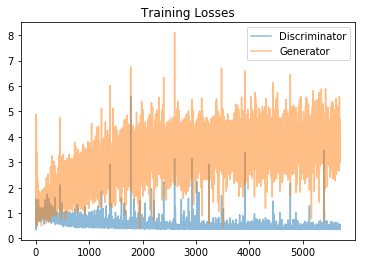

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [30]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

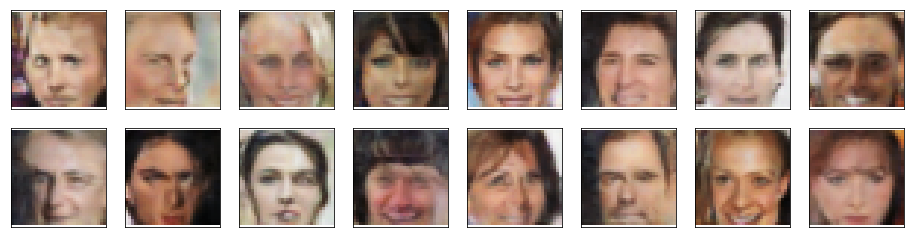

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** I noticed stabilizing it is very hard. Even slight changes to original DCGAN structure results different outputs. Although,  I managed to get modified DCGAN with added resnet architecture with good differential results. I've got following idea to improve the model. Here are the ideas:

1) Looking at the original dataset, It is not diversered at all. People of different races, shapes are not included. This may heavily influence to generated data.Even they are not evenly distributed. Although for deeper networks noise don't effect but if noise is in greater quantity it does effect. Some noise like cropped jawline should be removed and dataset should be carefully collected.

2) We need to go deeper. As we know , The more we go deeper ,more we'll be able to get features. So, If we add more layers to it and tried to experiment with different hyperparameter, we would be able to must get good results, its obvious.I did tried to go some deeper, we can go more, but can take computing power and time.

3) On seeing the papers of cycleGAN for higher resolution images. They mentioned to use architecture of 'conv-batchnorm-relu-dropout', I tried to add this kind of architecture with dropout in generator network and it worked. As our lecture suggest labels_smoothing , worked rather than not smoothing. Before generator was to smart after some iteration it gone to zero , and label smoothing helped. Also as mentioned in DCGAN paper and cycleGAN paper i have lr= 0.0002, beta1 = 0.5, beta2 = 0.9999. For getting the intuition on training i had used seen ganhacks by soumith , helped really. Like for up sampling I used convtranspose +stride and for downsampling conv+stride , added batch norm. For tracking failures early i used Failure mode idea. However, using SGD on discriminator and Adam on generator, caused failure mode in my case so i used Adam for both.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.